# SCP Foundation Analysis
## Team 5

- Lee Fenuccio
- Connor Brown
- Rudra Sett

## Abstract

This project tackles analysis of SCP Foundation entities, which are part of the larger SCP worldbuilding project. Data on specific attributes for each entity was collected via webscraping off of the SCP Foundation website. We also built a recommender for recommending similar entities. In the future, the recommender could be implemented on the SCP Foundation website, and the analysis could be extended to other parts of the website.  We also used a k-means algorithm to cluster the entities into categories and tested to see if the collected data could be used to predict the Object Class of the entities using a Decision Tree.

## Introduction 

Imagine a world full of mysterious creatures and phenomena that cannot be explained by any known science, many of which are dangerous. This type of world would require an organization to step forward to protect the world from these anamolous threats. This organization is the SCP Foundation, and it exists as a part of an Internet-wide collaborative worldbuilding project. Millions of people engage with this project, from casual readers, to devoted creators who make stories, videos, books, and games based on it. Since it is so popular, we decided it would warrant analysis. The goal is to make the world more accessible to everyone involved in it, so the entities can be grouped better and become more easily discoverable.

## Data Description

### Overview 
The entities are each uniquely numbered, and have their own unique webpage. We will scrape data off of the [SCP Wiki](https://scp-wiki.wikidot.com/) to obtain data for each entity. Our pipeline will extract specific attributes of an SCP and put them into a dataframe to be used for analysis. Below is a sample of a page for an SCP off of the SCP wiki, [SCP-1057](https://scp-wiki.wikidot.com/scp-1057). 
![Wiki](https://i.imgur.com/M9CMf8k.png)

Some easily visible attributes of the entity's entry are its number (1057), Class (Safe), Rating (+782), and tags (animal, aquatic, etc). Based on a more in depth knowledge about SCPs, there are other tropes that we searched the scraped text for, such as if the entity's entry had any blacked out or redacted information, mentions of special agents, sub-objects, etc. 

Overall, for each entity we gathered string data for tags and sub-objects, numeric data for number of positive ratings, number of all ratings, and word count, and boolean data (1 or 0 for if the entry contained info about a trope) for 5 different object classes (Safe, Euclid, Keter, Thaumiel, Anamolous, Neutral), D-Class, containment breach, addendum, task force, O5 council, agent, expunged, redacted, and blacked out. 

### Pipeline Overview

We will accomplish this task with the following functions:

#### Webscraping 
- `get_scp_soup()`
    - gets soup object for a given scp number
- `get_scp_maintext()`
    - gets the main text from the scraped scp
- `get_class()`
    - gets the verbatim class of the scraped scp
- `get_class_booleans()`
    - gets boolean values for the 5 main classes
- `get_rating()`
    - gets the positive and overall ratings from the scraped scp
- `get_subobjects()`
    - get a list of subobjects 1-9 and A-Z that exist in scraped scp
- `get_tags()`
    - gets the tags for the scraped scp
- `get_dict()`
    - gets the dictionary with attributes for a certain scp
- `scp_num()`
    - changes number to be readible by the scp wiki html
    
#### Tree stuff


#### Cluster stuff

- The k-means clustering algorithm uses no self-developed functions.
    
#### Recommendation algorithm
- `my_tokenizer()`
    - a tokenizer that keeps single characters
- `turn_data_into_arrays()`
    - turns original dataframe into a dataframe with arrays
- `get_similarities()`
    - gets cosin similarities
- `recommend_scp()`
    - recommends scps based on inputted scp

In [7]:
# import all needed libraries/packages
import requests
import json
from bs4 import BeautifulSoup
import string
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import webbrowser  
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from copy import copy

In [ ]:
def get_scp_soup(scp):
    '''gets Beautiful Soup of the given scp number
    Args:
        scp (int): the number of the scp 
    Returns:
        scp_soup (Beautiful Soup object): soup object from the scp html
    '''
    # first, it gets the html for the given scp
    url = f'https://scp-wiki.wikidot.com/scp-{scp}'
    html = requests.get(url).text
    
    # get the soup for the html
    scp_soup = BeautifulSoup(html)
    
    # return the soup
    return(scp_soup)

In [ ]:
def get_scp_maintext(num, scp_soup):
    '''gets the main story text from the scp soup object
    Args:
        num (int): the number of the scp the soup is for
        scp_soup (Beautiful Soup object): soup object for the scp's webpage
    Returns:
        scp_story (str): string that contains the story from the scp webpage
    '''
    # get the text using div and page-content from the soup
    scp_fulltext = (scp_soup.find("div", id = "page-content")).text
    
    # the text potentially has things before and after the actual story, so subset this text into just the story
    # we are assuming the story starts once the item is named (Item #: SCP-XXXX)
    # we are assuming the story ends when the bottom of the screen displays links to the next/previous story (« SCP-XXXX - 1)
    # not all SCPs are in this format- if the scp is not in this format, then the text will be ''
    
    # create the words that indicate the story starts/stops and find its location in the full text
    start = scp_fulltext.find(f'Item #: SCP-{num}')
    stop = scp_fulltext.find(f'« SCP-{int(num)-1}')
    
    # subset the full text by these location
    scp_story = scp_fulltext[start : stop]
    
    
    # there are some special cases of scps in different formats- if the above code didn't get the text, try the special case
    if len(scp_story) == 0:
        start = scp_fulltext.find(f'Item#: {num}')
        scp_story = scp_fulltext[start : stop]
        
    if len(scp_story) == 0:
        start = scp_fulltext.find(f'Item#: SCP-{num}')
        scp_story = scp_fulltext[start : stop]
    
    return(scp_story)

In [ ]:
def get_rating(soup):
    '''gets the positive and overall ratings for the scp
    Args:
        soup (Beautiful Soup object): soup for the scp
    Return:
        ratings (list): list with positive rating, overall rating    
    '''
    # get the 8th class=image, which is the image of the rating box, and get the src, which is the link
    text = soup.find_all(class_ = "image")[7]["src"]
    
    # clean the link to get the ratings from it
    link = text.split("&")
    ratings = [int(link[3].replace("rating=", "")), int(link[4].replace("rating_votes=", ""))]
    
    return(ratings)

In [ ]:
def get_subobjects(num, text):
    '''gets a list of the letters of all subobjects for an scp
    Args:
        num (int): the number of the scp
        text (str): the text of the main scp story
    Return:
        sub_objects (list): a list of the letters for all sub objects    
    '''
    # create string for subobjects
    sub_objects = ""
   
    # create list of all possible subobjects (1-100, A-Z)
    possible_subobjs = list(string.ascii_uppercase) + list(range(1, 101))
    
    # go through each subobject and see if its in the text
    for i in possible_subobjs:
        # check if subobject in text
        is_sub = f'SCP-{num}-{i} ' in text
        # if it is in the text, add it to the string
        if is_sub == True:
            if len(sub_objects) > 0:
                sub_objects = sub_objects + " " + str(i)
            else:
                sub_objects = str(i)
    
    # if there are subobjects, return them as string (each object seperated by space)
    if len(sub_objects) > 0:
        return sub_objects
    # otherwise return the word "None"- word will be used for similarity analysis
    else:
        return("None")

In [ ]:
def get_tags(soup):
    ''' gets the tags on the bottom of the page for the scp
    Args:
        soup (Beautiful Soup object): the beautiful soup object for the scp
    Returns:
        tags (list): a list of the tags
    '''
    # get the part of the soup that has the page tags
    scp_tags = soup.find(class_ = "page-tags")
    
    # the page tags is an amalgamation of things, seperate them by their a to get a list of each tag
    scp_tags_list = scp_tags.find_all("a")

    # loop over the tags and add the text of all the tags to a string seperated by commas
    tags = ""
    for tag in scp_tags_list:
        # some tags start with"_", we dont want those, so only add ones that don't start with "_"
        if (tag.text)[0] != "_":
            if len(tags) > 0:
                tags = tags + " " + tag.text
            else: 
                tags = tag.text
        
    return(tags)

In [ ]:
def get_class(text):
    '''returns class of SCP based on SCP text
    Args:
        text (str): text of SCP page (according to scp_dataframe())
    Return:
        class (str): string of SCP class (e.g. 'Euclid')
    '''
    try:
        start = text.index("Object Class:")
        text = text[start+14:]
        end = text.index("\n")
    except ValueError:
        try:
            start = text.index("Containment Class:")
            text = text[start+19:]
            end = text.index("\n")
        except:
            return None
    
    return text[:end]

In [ ]:
def get_class_booleans(class_str):
    '''returns booleans for Safe, Euclid, Keter, Thaumiel, Anomalous, Neutralized
    Args:
        class_str (str): text of class directly from web-scrape
    Return:
        safe, euclid, keter, thaumiel, anom, neutral (all boolean)
    '''
    
    safe, euclid, keter, thaumiel, anom, neutral = 0, 0, 0, 0, 0, 0
    
    if "Safe" in class_str:
        safe = 1
    if "Euclid" in class_str:
        euclid = 1
    if "Keter" in class_str:
        keter = 1
    if "Thaumiel" in class_str:
        thaumiel = 1
    if "Anomalous" in class_str:
        anom = 1
    if "Neutralized" in class_str or "NEUUtrallized" in class_str:
        neutral = 1
        
    return safe, euclid, keter, thaumiel, anom, neutral

In [ ]:
def get_dict(num):
    ''' get a dictionary with information about different attributes for an scp
    Args:
        num (str or int): number of scp

    Returns: 
       dic_scp (dict): dictionary with information about different attributes for the scp    
    '''
     # create dic to add scp attributes to
    dic_scp = {}
    
    # get the random scp's soup (Beautiful Soup object)
    soup = get_scp_soup(num)
           
    # get rating of scp
    ratings = get_rating(soup)
        
    # get the tags of the scp
    tags = get_tags(soup)

    # get the main text of the scp
    text = get_scp_maintext(num, soup)
     
    # get class of scp
    scp_class = get_class(text)
    safe, euclid, keter, thaumiel, anom, neutral = get_class_booleans(scp_class)
    
    # get word count
    word_count = len(text.split())
        
    # get sub objects
    sub_objects = get_subobjects(num, text)
        
    # getting  1 or 0 for if certain things are in the text:
    dclass = int("D-Class" in text) or int("D-class" in text) or int("Personnel D-" in text)
    blacked_out = int("█" in text)
    redacted = int("REDACTED" in text)
    expunged = int("EXPUNGED" in text)
    agent = int("agent" in text) or int("Agent" in text)
    O5 = int("O5" in text)
    task_force = int("Mobile Task Force" in text)
    addendum = int("Addendum" in text)
    breach = int("containment breach" in text) or int("Containment breach" in text)
     
    # create dic to add scp attributes to, to eventually add to dataframe
    dic_scp = {"Number" : num, "Pos Ratings" : ratings[0], "All Ratings" : ratings[1], "Tags" : tags, 
               "Sub-Objects" : sub_objects, "Word Count" : word_count, 
               "Safe" : safe, "Euclid" : euclid, "Keter" : keter, "Thaumiel" : thaumiel, "Anomalous" : anom,
               "Neutral" : neutral, "D-Class" : dclass, "Containment Breach" : breach, "Addendum" : addendum,
               "Task Force" : task_force, "O5 Council" : O5, "Agent" : agent, "[EXPUNGED]" : expunged, 
               "[REDACTED]" : redacted, "Blacked Out" : blacked_out
                }
    return(dic_scp)

In [ ]:
def scp_num(num):
    '''changes number to be readible by the scp wiki html
    Args:
        num (int or str): number
    Returns:
        n (str): number in format readible by scp wiki html (so 45 becomes 045)
    
    '''
    n = "000" + str(num)
    while len(n) > 4:
        n = n.replace("0", "", 1)
    if n[0] == "0":
        n = n.replace("0", "", 1)
    return(n)

In [ ]:
#create list of all scp numbers
#the first 99 numbers need to be changed to have 0 or 00 in front
num_list = []
for i in range(1, 100):
    num_list.append(scp_num(i))
num_list = num_list + (list(range(100, 8000)))

In [ ]:
# Normally, all of this code would be run- however it takes about 2 hours to run it since it is getting information for EVERY
# entity, so we only ran it once then saved the results as a csv, and used the csv for the rest of the project

#create dictionary for every possible scp, and add to dataframe
#scp_df = pd.DataFrame()

# loop through all the numbers, add to dataframe only if it was able to get the text
#for i in num_list:
    #try:
        #scp_dict = get_dict(i)
        #scp_df = scp_df.append(scp_dict, ignore_index=True)
    #except: 
        #pass
#scp_df.head()

#save the dataframe to a csv
#scp_df.to_csv("all_scps_final.csv")

In [5]:
# we ran the above code once, and got a csv of all the scp data. For the rest of the project, we imported that csv and used it
df = pd.read_csv("all_scps_final.csv")

# check out the data!!!
df.head()

,Number,Tags,Sub-Objects,Pos Ratings,All Ratings,Word Count,Safe,Euclid,Keter,Thaumiel,...,Neutral,D-Class,Containment Breach,Addendum,Task Force,O5 Council,Agent,[EXPUNGED],[REDACTED],Blacked Out
0,2.0,alive euclid featured scp structure transfigur...,None,1832.0,2206.0,857.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,3.0,alive biological computer director-moose eucli...,1 2,824.0,1056.0,1789.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,4.0,euclid mind-affecting portal scp spacetime str...,1 2 7 12 13 14,1154.0,1340.0,1452.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,5.0,adaptive safe scp,None,710.0,1268.0,373.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,liquid location medical rewrite safe scp self-...,None,686.0,1212.0,491.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


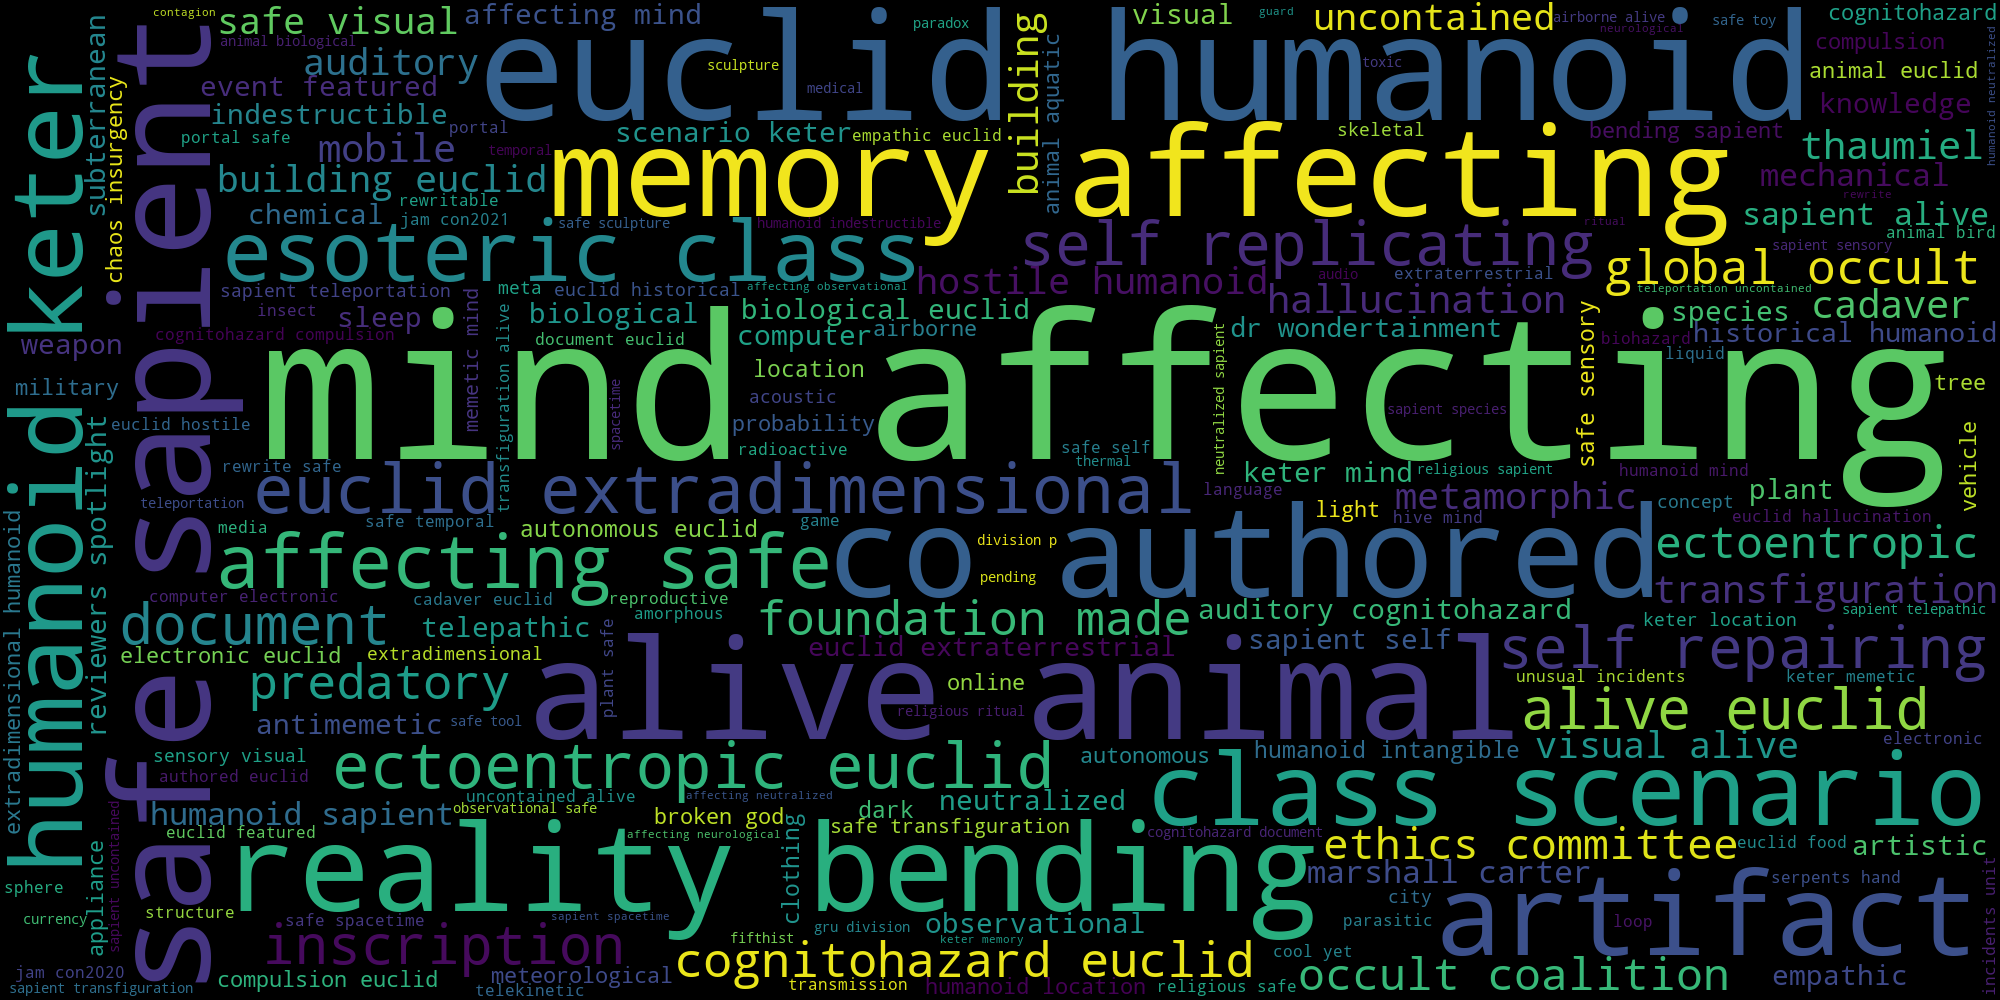

<Figure size 1200x800 with 0 Axes>

In [6]:
# to visualize a bit of the data, we made a wordcloud for all of the tags
# put all the tags together in a single string
tags = " ".join(df["Tags"])

# scp is a tag for basically every one, remove so it isnt cluttering
tags = tags.replace("scp", "")

# make word cloud
cloud = wordcloud.WordCloud(width=2000, height=1000)
plt.figure(dpi=200)
cloud.generate_from_text(tags)
cloud.to_image()

Text(0.5, 0, 'Class')

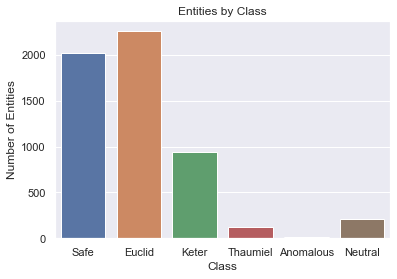

In [7]:
# count how many of each type there are

# set classes
classes = ["Safe", "Euclid", "Keter", "Thaumiel", "Anomalous", "Neutral"]

# make empty list to hold amount in each class
amount = []

# for each class, count the amount of scps
for i in classes:
    class_ = df[df[i] == 1][i].count()
    amount.append(class_)

# plot results
sns.set()
sns.barplot(x = classes, y = amount)
plt.title("Entities by Class")
plt.ylabel("Number of Entities")
plt.xlabel("Class")

## Methods

####  Recommendation
Cosine similarity was chosen to make a recommendation algorithm for entity entries. Cosine similarty was chosen so the tags and objects could be incorporated into the recommendation. By finding the cosine similarity between different SCP articles, we can recommend similar articles. This could be useful to implement on the website to recommend similar articles to readers. One pitfall is that it is difficult to quantify how well the recommender is working, or how each cosine similarity should be weighted. This can be counteracted with lots of trial and error to see how well the recommender works, as well as using extensive knowledge of the SCP Foundation to decide how much to weight each factor. 

#### K-means

A k-means clustering algorithm was used in order to discover what SCP features the algorithm would gravitate to in order to group SCPs together. This was done with the hopes that the clustering would identify similarities within SCP classes and each resulting cluster would essentially be representative of a particular class of SCP. Such a classifier could be useful in reccomending SCPs as with the cosine similarity method discussed above; reccomending only SCPs within the same cluster, for example, may reveal more accurate predictions.

#### Tree

Two different methods were used to try to build a tree.

##### Tags

The first method was to use the tags.

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

def get_most_important_tags(df : pd.DataFrame, n_tags = 175):
  ''' goes through the entire dataframe and gathers the most important tags via TF-IDF (inverse document frequency; picks important tags with lower weights to tags that appear too often)
    Args:
        df (dataframe): dataframe containing all scps with original data
        n_tags (int): the number of tags to return
    Return:
        most_important_tags (np.array): list of the n_tags most important tags, ordered by importance
  '''
  vectorizer = TfidfVectorizer(max_features=n_tags,stop_words='english')
  vectorizer = vectorizer.fit(df["Tags"])
  most_important_tags = vectorizer.get_feature_names_out()
  return most_important_tags

This convert_tags_to_vector turns each set of tags into a list the same length as the number of important tags. This allows us to treat the set of tags as a set of features. Each column in this vector/list corresponds to the same word. Having a 1 in a column means that the tag that column corresponds to was one of the tags for that SCP.

In [ ]:
def convert_tags_to_vector(tags : str, important_tags):
  ''' takes a list of tags from an individual SCP 
    Args:
        tags (str): a space-separated list of tags in string form
        important_tags (np.array): the list of important tags derived from get_most_important_tags
    Return:
        vec (list): the list of tags turned into a sparse (has zeros) vector
  '''
  vec = []
  for tag in important_tags:
    if tag in tags:
      vec.append(1)
    else:
      vec.append(0)
  return vec

In [ ]:
df.iloc[10]["Tags"]

In [ ]:
convert_tags_to_vector(df.iloc[10]["Tags"])

In [ ]:
X = df["Tags"].apply(convert_tags_to_vector)
x = np.array(X.tolist())

In [ ]:
def convert_row_to_class(row):
  classes = ['Safe', 'Euclid', 'Keter', 'Thaumiel', 'Anomalous',
       'Neutral']
  scp_class = ""
  for c in classes:
    if row[c] == 1.0:
      scp_class = c
  if scp_class == "": scp_class = "Unknown"
  return scp_class

In [ ]:
Y = df.apply(convert_row_to_class, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np

Single tree so that we can see what the tree looks like

In [ ]:
# get x features
x_feat_list = get_most_important_tags(df)

dec_tree_clf = tree.DecisionTreeClassifier(max_depth=2)

# fit data
dec_tree_clf = dec_tree_clf.fit(x, Y)

# initialize empty figure (plot_tree sets text size to fill given figure
# if we resize figure afterwards text size remains too small)
plt.figure()
plt.gcf().set_size_inches(15, 10)

# 'plot' decision tree
tree.plot_tree(dec_tree_clf, 
               feature_names=x_feat_list,
               class_names=dec_tree_clf.classes_);

Random Forest to get our final accuracy score

In [ ]:
n_splits = 10
max_depth = 200

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
rf_clf = RandomForestClassifier(n_estimators=500)

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(Y)

for train_idx, test_idx in skfold.split(x, Y):
    # get training data
    x_train = x[train_idx, :]
    y_train = Y[train_idx].tolist()
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    rf_clf = rf_clf.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = rf_clf.predict(x_test)

In [ ]:
accuracy_score(Y.tolist(),y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, r2_score

In [ ]:
conf_mat = confusion_matrix(y_true=Y, y_pred=y_pred)

conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(Y))
conf_mat_disp.plot()

plt.gcf().set_size_inches(10, 10)

# seaborn turns on grid by default ... looks best without it
plt.grid(False)

##### Full Text

In [ ]:
from nltk.tokenize import word_tokenize
import contractions
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
import string
import wordcloud
from plotly import express as px

In [ ]:
def fix_pos(pos):
  '''corrects the part of speech to something the lemmatizer can actually read
    Args:
        pos (str): the part of speech returned by the POS tagger
    Return:
        str: the correct type of part of speech
  '''
  # if tag not in ["DT","JJ","POS","WP","PRP$","IN","CC","CD","WRB","PRP","TO","MD",".","WDT"]
  correct = ["A","V","N","R"]
  pos = pos[0]
  if pos in correct:
    return pos.lower()
  else:
    return 'n'

In [ ]:
def clean_text(text):
  '''cleans a given SCP story for further analysis
    Args:
        text (str): the story in the form of a str
    Return:
        cleaned_text (str): the story with special characters removed and 
  '''   
 
  # expand contractions
  text =  contractions.fix(text)

  # make a string translation table (not sure how common this is, but I've used it before; there are definitely lots of other ways to do this!)
  table = str.maketrans(string.punctuation,' '*len(string.punctuation))
  # the reason this is here is because I actually don't want dashes removed
  table.update({ord("-"): '-'})
  # remove punctuation other than dashes (so SCP-XXXX doesn't become SCP XXXX)
  text = str.translate(text,table)

  # split the text into words
  tokens = word_tokenize(text)
  # tag the words with part of speech
  tagged_text = pos_tag(tokens)
  
  # convert words to their roots (i.e. staffing to staff)
  lemmatizer = WordNetLemmatizer()
  lemmatized = [lemmatizer.lemmatize(word,fix_pos(tag)) for word, tag in tagged_text]

  # join the words back into one document again and return them
  cleaned_text = " ".join(lemmatized)
  return cleaned_text

In [ ]:
def clean_texts(texts : list):
  '''cleans a list of strings
    Args:
        texts (list): the list of texts
    Return:
        cleaned (list): the list of texts, but each text is cleaned
  '''  
  cleaned = []
  for i,text in enumerate(texts):
    cleaned.append(clean_text(text))
    #print(f"Cleaned SCP {i}")
  return cleaned

In [ ]:
texts = df["Text"]
cleaned = clean_texts(texts)

The texts were used in 3 ways: Bag-of-Words model, vectors, and sklearn's sparse document vectors.

- Bag of Words: this method turns each document into a binary vector, where each position in the vector corresponds to a specific word, and a 1 at that position indicates that this word is in the original document.
- Vectors: this method turns each word into a unique number and returns each piece of text as a list of these numbers
- Sparse document vectors: sklearn can turn a set of documents into a sparse matrix; there's not a lot of information on how this works but I used it anyway

In [ ]:
num_features = 20000

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=num_features,stop_words='english')
vectorizer = vectorizer.fit(cleaned)
most_important_words = vectorizer.get_feature_names()

In [ ]:
def convert_doc_to_vec(doc : str):
  vec = []
  for word in doc.split(" "):
    try:
      vec.append(vectorizer.vocabulary_[word])
    except KeyError:
      pass
  return vec


Unfortunately, beacuse of how this method works, not all of the vectors, or features, will be the same length - this is a problem that can be fixed with an extra function.

In [ ]:
import numpy as np

In [ ]:
vec_len = 500

def pad_vectors(vector_list : list):
  vec_padded = []
  for v in vector_list:
    cl = len(v)
    padded = v + [0] * max(vec_len - cl,0)
    vec_padded.append(padded[0:500])

This is how we'd convert the documents to bag of words instead.

In [ ]:
def convert_doc_to_bow(doc : str):
  vec = []
  for word in most_important_words:
    if word in doc:
      vec.append(1)
    else:
      vec.append(0)
  return vec

In [ ]:
sparse_vectors = vectorizer.transform(cleaned)

In [ ]:
bow_vectors = []
for doc in cleaned:
  bow_vectors.append(convert_doc_to_bow(doc))
bow_vectors = np.array(bow_vectors)

In [ ]:
vec = []
for doc in cleaned:
  vec.append(convert_doc_to_vec(doc))
vectors = np.array(pad_vectors(vec))

Now to plot these and put them into a tree!

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Plot the regular vectors

In [ ]:
pca = PCA(n_components=2).fit(vectors)
reduced = pca.transform(vectors)

In [ ]:
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=Y)
plt.show()

Plot the Bag-of-Words vectors

In [ ]:
pca = PCA(n_components=2).fit(bow_vectors)
reduced = pca.transform(bow_vectors)

In [ ]:
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=Y)
plt.show()

Finally, plot the sklearn vectors. These seem to be the best representation.

In [ ]:
pca = PCA(n_components=2).fit(sparse_vectors)
reduced = pca.transform(sparse_vectors)

In [ ]:
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=Y)
plt.show()

Now that we've seen what these vectors look like, we can try some trees. However, only the bag-of-words vectors make sense to use with trees, because they're the only ones where the columns are interpretable variables (represents a specific word).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np

# get x features
x_feat_list = most_important_words

dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)

# fit data
dec_tree_clf = dec_tree_clf.fit(bow_vectors, Y)

# initialize empty figure (plot_tree sets text size to fill given figure
# if we resize figure afterwards text size remains too small)
plt.figure()
plt.gcf().set_size_inches(15, 10)

# 'plot' decision tree
tree.plot_tree(dec_tree_clf, 
               feature_names=x_feat_list,
               class_names=dec_tree_clf.classes_);

## Results

#### Recommendation

In [ ]:
def my_tokenizer(text):
    '''tokenizer that keeps single character
    Args:
        text (str): text to be tokenized
    Return:
        re.splot("\\s+", text) (str): good text
    '''
    # create a space between special characters 
    text=re.sub("(\\W)"," \\1 ",text)
    # split based on whitespace
    return re.split("\\s+",text)

In [ ]:
def turn_data_into_arrays(df):
    ''' turns the scp dataframe into a dataframe with arrays representing the tags, objects, and other values for each scp
    Args:
        df (dataframe): dataframe containing all scps with original data
    Return:
        df_array (dataframe): dataframe containing all scps with data in arrays comparible by cosine similarity    
    '''
    # vectorize the Tags and Sub-Objects columns, save them as arrays
    vectorizer = CountVectorizer(tokenizer = my_tokenizer)
    objects_array = vectorizer.fit_transform(df["Sub-Objects"])
    objects_array = objects_array.toarray()

    vectorizer = CountVectorizer()
    tags_array = vectorizer.fit_transform(df["Tags"])
    tags_array = tags_array.toarray()

    # make the arrays into lists and add them into their own columns in a new dataframe
    df_array = pd.DataFrame()
    df_array["Number"] = df["Number"]
    df_array = df_array.set_index("Number")
    df_array["Tags Array"] = list(tags_array)
    df_array["Objects Array"] = list(objects_array)

    # turn the other x features in the dataframe into an array
    # all x features that need to be normalized
    x_to_normalize = ["Pos Ratings", "All Ratings", "Word Count"] 

    # normalize the x features in new dataframe
    df_norm = pd.DataFrame()
    for feat in x_to_normalize:
        df_norm[feat] = df[feat] / df[feat].std()
    x_feats = ["Safe", "Euclid", "Keter", "Thaumiel", "Anomalous", "Neutral", "D-Class", "Containment Breach", 
               "Addendum", "Task Force", "O5 Council", "Agent", "[EXPUNGED]", "[REDACTED]", "Blacked Out"]
    # add the rest of the x features into the dataframe
    for feat in x_feats:
        df_norm[feat] = df[feat]
    
    # extract data into numpy format
    num_array = df_norm.values

    # add numpy array to df_array
    df_array["Num Array"] = list(num_array)
    
    return(df_array)

In [ ]:
def get_similarities(scp, df_array):
    ''' # gets cosin similarities between given scp and all other scps, returns scps with closest similarities
    Args:
        scp (int): the number of the scp you want similar ones to
        df_array (dataframe): a dataframe with arrays representing the tags, subobjects, and other values from the original 
                                dataframe containing all scps
    Returns:
        similarities (dataframe): the similarity scores for each scp to the given scp
    '''
    # get vectors for the given scp
    tag_vec = df_array.loc[scp]["Tags Array"]
    obj_vec = df_array.loc[scp]["Objects Array"]
    num_vec = df_array.loc[scp]["Num Array"]
   
    # get similarity to the given scp for each scp in the dataframe, store in dataframe with scp number
    # create dataframe with a column as the scp number
    similarities = pd.DataFrame(columns = ["Number", "Similarity"])
    
    # for each scp, calculate the similarity score and put into Series
    for idx, row in df_array.iterrows():
       # get vectors for current scp
        tag2_vec = df_array.loc[idx]["Tags Array"]
        obj2_vec = df_array.loc[idx]["Objects Array"]
        num2_vec = df_array.loc[idx]["Num Array"]
        
        # calculate similarities for given scp and each scp
        tag_sim = cosine_similarity(tag_vec.reshape(1, -1), tag2_vec.reshape(1, -1))
        obj_sim = cosine_similarity(obj_vec.reshape(1, -1), obj2_vec.reshape(1, -1))
        num_sim = cosine_similarity(num_vec.reshape(1, -1), num2_vec.reshape(1, -1))
        
        # calculate overall similarity by adding
        # weight the factors as desired- objects are worth less, tags are worth a lot
        overall_sim = (2*tag_sim) + (0.5*obj_sim) + (0.75*num_sim)
        overall_sim = round(overall_sim[0][0], 2)
        
        # add similarites together and put into dataframe
        similarities = similarities.append({"Number" : idx, "Similarity": overall_sim}, ignore_index=True)
    
    # sort the similarites descending
    similarities.sort_values(by=['Similarity'], ascending = [False], inplace=True)
    
    return(similarities)

In [ ]:
def recommend_scp(scp, df_array, df_scp, num_recs = 5, open_first = True):
    '''recommends a certain number of scps based on a given scp, displays their info in table and opens first recommendation
    Args:
        scp (int): number of scp
        df_array (dataframe): dataframe with arrays representing the tags, subobjects, and other values from the original 
                                dataframe containing all scps
        df_scp (dataframe): the original dataframe containing all scps
        num_recs (int): the number of recommendations to return
        open_first (boolean): whether or not to automatically open a tab for the first recommendation
    Returns:
        df_recs (dataframe): a dataframe with info, including links and similarity score, for the top similar scps
    
    '''
    # possibly put part in for what to do if scp not in the array
    
    # get the similarities
    similarities = get_similarities(scp, df_array)
    
    # get top (num_recs) in the similarities
    recs = list(similarities.iloc[0:num_recs + 1]["Number"])
    
    # create links to the top (rec) similar ones
    links = []
    for i in recs:
        # make sure scp number is in proper format for link
        # turn float into int and string
        i = str(int(i))
        # if the number is less than 3 numbers long, must add zeros in front
        while len(i) < 3:
            i = '0' + i   
            
        # create link  
        link = f'https://scp-wiki.wikidot.com/scp-{i}'
        links.append(link)
        
    # create new dataframe with the top recommended scps
    df_recs = pd.DataFrame()
    for i in recs:
        df_recs = df_recs.append(df_scp.loc[df["Number"] == i])
    
    # add links as a row in the dataframe
    df_recs["Link"] = links
    
    # add the similarity score to the dataframe, set similarity score of original to say "original"
    sim_score = list(similarities.iloc[0:num_recs + 1]["Similarity"])
    sim_score[0] = "Original"
    df_recs["Similarity Score"] = sim_score
    
    
    # open the top recommendation if open_first = True
    if open_first == True:
        webbrowser.open_new_tab(links[1])
        
    # make Number the index, add link and similarity score to the front of the dataframe
    df_recs = df_recs.set_index("Number")
    cols_to_move = ["Similarity Score", "Link"]
    df_recs = df_recs[cols_to_move + [x for x in df_recs.columns if x not in cols_to_move]]
    
    # return the top recommendations
    return(df_recs)

In [ ]:
# turn the scp dataframe into array for the recommendation function
df_array = turn_data_into_arrays(df)

In [ ]:
# check how long it takes the recommendation function to run
startTime = time.time()

# run recommendation function
og_scp = 5167
num_recs = 10
recs = recommend_scp(og_scp, df_array, df, num_recs)

# print function run time
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

# print scp recommendations
recs

Some examples of results:
SCP-1509 was put in to find a similar one.
Returned SCP-3118.
1509 is a knife that, when someone is cut with, ants come out of the wound.
3118 is gun that, when fired at someone's head, a lunch that the person once ate spontaneously appears. 

Another is https://scp-wiki.wikidot.com/scp-3126.
It returned https://scp-wiki.wikidot.com/scp-706.
3126 is a woman whose skin turns to iron when she is near a strong magnet.
706 is a girl who had porcelain skin.

Another is https://scp-wiki.wikidot.com/scp-1336. It returned https://scp-wiki.wikidot.com/scp-1161. 1336 is a sheet of paper whose contents constantly shift and occasionally form a picture of the structure of a new organic compound. 1161 is a book that, every day, contains different how-to instructions for a different random task.

#### K-Means

In [6]:
# Read in the csv with SCP data
df_gtky = pd.read_csv("all_scps_final.csv")
df_gtky.dropna(inplace=True)

# Create column for Positive Rating rate, bc why not?
df_gtky['PosRating Rate'] = df_gtky['Pos Ratings'] / df_gtky['All Ratings']

In [8]:
#Normalize numeric (i.e. non-boolean) data
x_feat_list0 = ['Number','Pos Ratings','All Ratings','Word Count','PosRating Rate']
    
df_gtky_scaled = copy(df_gtky)

# scale normalization of numeric variables
for feat in x_feat_list0:
    df_gtky_scaled[feat] = df_gtky_scaled[feat] / df_gtky_scaled[feat].std()

Text(0, 0.5, 'mean dist^2 to centroid')

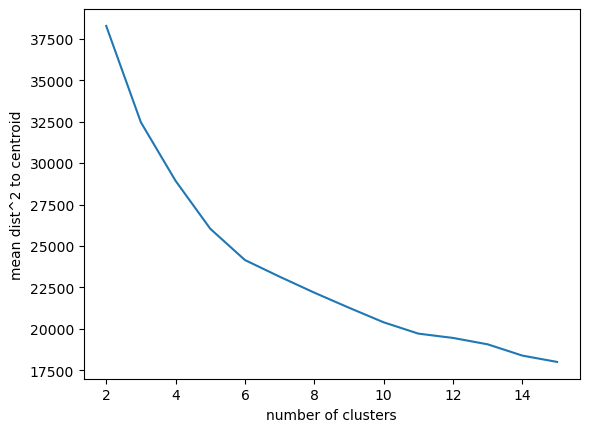

In [9]:
# replace 1s and 0s with True and False
for i, jo in df_gtky_scaled.iterrows():
    # iterate thru boolean fields and reassign vals
    for x in ['Safe', 'Euclid', 'Keter', 'Thaumiel', 'Anomalous', 'Neutral', 'D-Class', 'Containment Breach', 'Addendum', 'Task Force', 'O5 Council', 'Agent', '[EXPUNGED]', '[REDACTED]', 'Blacked Out']:
        if jo[x] == 0:
            df_gtky_scaled.loc[i, x] = False
        elif jo[x] == 1:
            df_gtky_scaled.loc[i, x] = True
            
# all feats to use in kmeans
x_feat_list1 = ['Number','Pos Ratings','All Ratings','Word Count', 'PosRating Rate', 'Safe', 'Euclid', 'Keter', 'Thaumiel', 'Anomalous', 'Neutral', 'D-Class', 'Containment Breach', 'Addendum', 'Task Force', 'O5 Council', 'Agent', '[EXPUNGED]', '[REDACTED]', 'Blacked Out']
x = df_gtky_scaled.loc[:, x_feat_list1].values

# Do Kmeans!
mean_d_dict = dict()
for n_clusters in range(2, 16):
    # fit kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)    
        
    # compute & store mean distance
    mean_d = -kmeans.score(x)
    mean_d_dict[n_clusters] = mean_d

# find the elbow to find k
plt.plot(mean_d_dict.keys(), mean_d_dict.values())
plt.xlabel('number of clusters')
plt.ylabel('mean dist^2 to centroid')

Based upon the graph above, we will run one analysis at k=3 and one analysis at k=6.

# k = 3

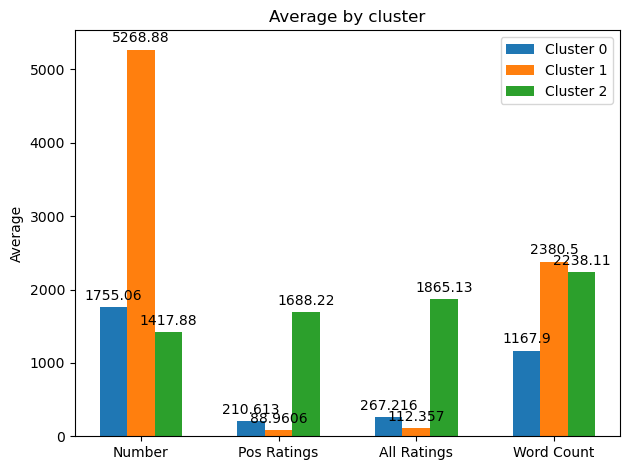

In [11]:
# fit and predict a kmeans with k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(x)
y = kmeans.predict(x)

# update DF with cluster info
df_gtky['cluster'] = y

# make another copy of orig DF
df_gtky2 = copy(df_gtky)
del df_gtky2['Tags']

# Start of Plotting Section
labels = ['Number','Pos Ratings','All Ratings','Word Count', 'PosRating Rate', 'Safe', 'Euclid', 'Keter', 'Thaumiel', 'Anomalous', 'Neutral', 'D-Class', 'Containment Breach', 'Addendum', 'Task Force', 'O5 Council', 'Agent', '[EXPUNGED]', '[REDACTED]', 'Blacked Out']

zero_means = []
one_means = []
two_means = []

# how to recover mean for a feature by row
for l in labels:
    for x in [0,1,2]:
        cluster_bool = df_gtky2['cluster'] == x
        if x == 0:
            zero_means.append(df_gtky2.loc[cluster_bool,:][l].mean())
        if x == 1:
            one_means.append(df_gtky2.loc[cluster_bool,:][l].mean())
        if x == 2:
            two_means.append(df_gtky2.loc[cluster_bool,:][l].mean())
            
x = np.arange(len(labels[:4]))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - width, zero_means[:4], width, label='Cluster 0')
rects1 = ax.bar(x, one_means[:4], width, label='Cluster 1')
rects2 = ax.bar(x + width, two_means[:4], width, label='Cluster 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average')
ax.set_title('Average by cluster')
ax.set_xticks(x, labels[:4])
ax.legend()

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

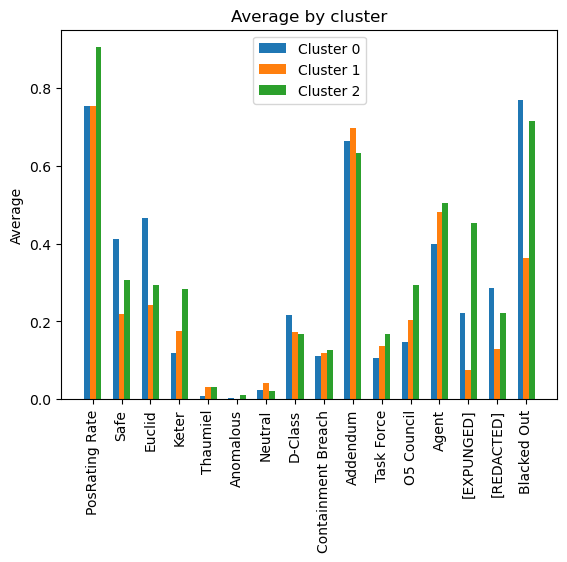

In [12]:
# do the same for the tags ranging from 0-1 (dont put them on the last chart...see how small 88 is?)

x = np.arange(len(labels[4:]))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - width, zero_means[4:], width, label='Cluster 0')
rects1 = ax.bar(x, one_means[4:], width, label='Cluster 1')
rects2 = ax.bar(x + width, two_means[4:], width, label='Cluster 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average')
ax.set_title('Average by cluster')
ax.set_xticks(x, labels[4:])
plt.xticks(rotation = 90)
ax.legend()

plt.show()

# k = 6

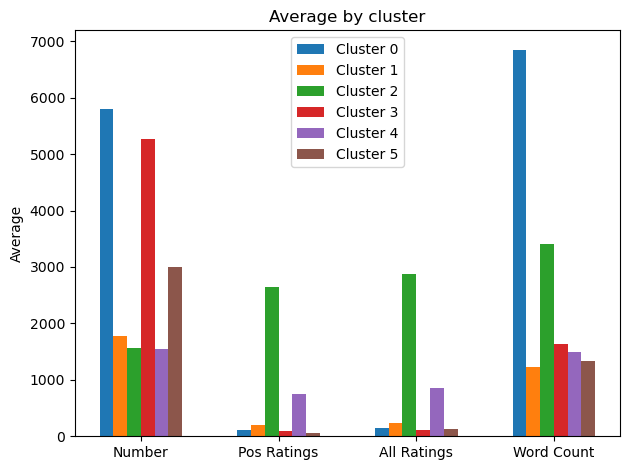

In [13]:
# do the same thing that you did with k=3 to k=6

x = df_gtky_scaled.loc[:, x_feat_list1].values

kmeans = KMeans(n_clusters=6)
kmeans.fit(x)
y = kmeans.predict(x)
df_gtky['cluster'] = y

labels = ['Number','Pos Ratings','All Ratings','Word Count', 'PosRating Rate', 'Safe', 'Euclid', 'Keter', 'Thaumiel', 'Anomalous', 'Neutral', 'D-Class', 'Containment Breach', 'Addendum', 'Task Force', 'O5 Council', 'Agent', '[EXPUNGED]', '[REDACTED]', 'Blacked Out']

zero_means = []
one_means = []
two_means = []
three_means = []
four_means = []
five_means = []

# how to recover mean for a feature by row
for l in labels:
    for x in [0,1,2,3,4,5]:
        cluster_bool = df_gtky['cluster'] == x
        if x == 0:
            zero_means.append(df_gtky.loc[cluster_bool,:][l].mean())
        if x == 1:
            one_means.append(df_gtky.loc[cluster_bool,:][l].mean())
        if x == 2:
            two_means.append(df_gtky.loc[cluster_bool,:][l].mean())
        if x == 3:
            three_means.append(df_gtky.loc[cluster_bool,:][l].mean())
        if x == 4:
            four_means.append(df_gtky.loc[cluster_bool,:][l].mean())
        if x == 5:
            five_means.append(df_gtky.loc[cluster_bool,:][l].mean())
            
x = np.arange(len(labels[:4]))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - (width * 2.5), zero_means[:4], width, label='Cluster 0')
rects1 = ax.bar(x - (width * 1.5), one_means[:4], width, label='Cluster 1')
rects2 = ax.bar(x - (width * 0.5), two_means[:4], width, label='Cluster 2')
rects3 = ax.bar(x + (width * 0.5), three_means[:4], width, label='Cluster 3')
rects4 = ax.bar(x + (width * 1.5), four_means[:4], width, label='Cluster 4')
rects5 = ax.bar(x + (width * 2.5), five_means[:4], width, label='Cluster 5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average')
ax.set_title('Average by cluster')
ax.set_xticks(x, labels[:4])
ax.legend()

"""ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.bar_label(rects5, padding=3)"""

fig.tight_layout()

plt.show()

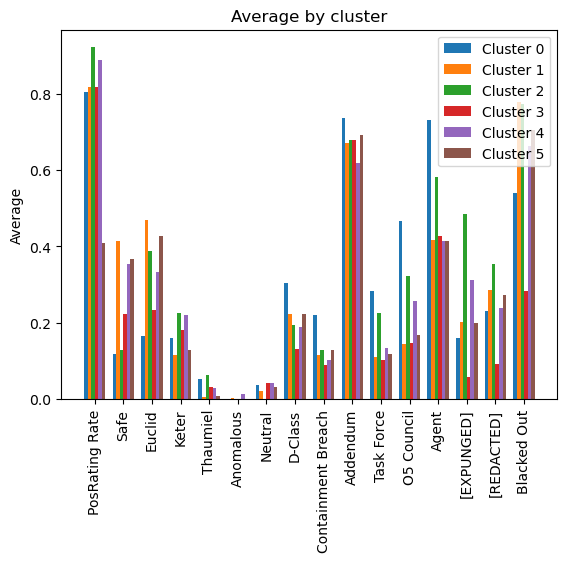

In [14]:
x = np.arange(len(labels[4:]))  # the label locations
width = 0.125  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - (width * 2.5) , zero_means[4:], width, label='Cluster 0')
rects1 = ax.bar(x - (width * 1.5), one_means[4:], width, label='Cluster 1')
rects2 = ax.bar(x - (width * 0.5), two_means[4:], width, label='Cluster 2')
rects3 = ax.bar(x + (width * 0.5), three_means[4:], width, label='Cluster 3')
rects4 = ax.bar(x + (width * 1.5), four_means[4:], width, label='Cluster 4')
rects5 = ax.bar(x + (width * 2.5), five_means[4:], width, label='Cluster 5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average')
ax.set_title('Average by cluster')
ax.set_xticks(x, labels[4:])
plt.xticks(rotation = 90)
ax.legend()

#fig.tight_layout()

plt.show()

## Discussion

#### Recommender
It's a bit difficult to determine how well the recommendation algorithm does with such a complex job. After several tests with different articles, the algorithm appears to sucessfully recommend articles with similar themes. Testing the algorithm on others outside the project also found success, and they enjoyed the recommended articles. The recommender shows potential, it could be used to recommend other pages on the scp wiki. Currently the website provides links to the next and previous entities at the bottom of each article, but it would make more sense to include recommendations for similar articles. This recommender could also be extended to incorporate other pages on the wiki, such as short stories, joke SCPs, etc.

#### K-Means
Although K-Means did NOT cluster based upon class as we had hoped, the results are still interesting.

Since there are three principal SCP classes (Safe, Euclid, and Keter), I ran an analysis with k=3. These three clusters can be characterized thusly:
* Cluster 0: SCPs in Cluster 0 are more likely to be non-Keter (i.e. Safe or Euclid) than SCPs in other clusters. They also have relatively low ratings when compared to the most popular stories. These are also by far the shortest stories.
* Cluster 1: SCPs in Cluster 1 were assigned high numbers for their Object ID, revealing that they were (generally) written later than other SCP stories (although there is not a straightforward relationship between SCP numbering and the date of the respective article). They also have the highest word count (but not by much) and lowest number of ratings, positive ratings, and proportion of positive ratings, meaning that these stories are long but not exhausting, and are fundamentally unpopular.
* Cluster 2: SCPs in Cluster 2 are popular with the community. They have the greatest mean value in all Rating features by a wide margin. Also notable for having an about-even proportion of the main three classes, whereas the other clusters contain mainly Safes and Euclids.

Then, because of the derivative change at k=6 in a graph of average distance (squared) from all data points in a cluster to that cluster's centroid, k=6 was analyzed. This analysis did not reveal much, as many of the clusters seemed similar. However, of note are: 

* Cluster 0 for having relatively new (high-numbered) and also very long stories compared to other clusters.
* Cluster 2, a cluster of popular stories. Similar to the previous Cluster 2, but more dramatic. Notable for its high relative proportion of Euclids (though its not even close to being a Euclid cluster), a word count substantially greater than most clusters (second to Cluster 0), and a very high incidence of the phrases of interest (like "Task Force" and "EXPUNGED").

The K-Means algorithm gravitates towards the fields which are not booleans. This may simply be because of normalization, as the range of non-boolean values is likely much greater than 1, whereas the difference between the most different boolean values is at most 1. However, if the dataset was correctly prepared, it makes sense that the ratings, word count, and recency of a post can characterize it without any information from inside the story itself. Things clustered in time are often more similar than things spread apart in time; word count is a fundamental aspect of a story; and the ratings reveal generally how people reflect upon a story and what they think its reputation should be.

This analysis was not developed alongside the reccomendation algorithm, so a combination has not been attempted, but it would be interesting to the future use of the reccomendation algorithm to experiment with reccomending only within clusters.